In [1]:
import os
from datetime import datetime, timedelta
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve, roc_auc_score,auc
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import random
from functools import partial
from dinov2.eval.linear import LinearClassifier
from dinov2.eval.utils import ModelWithIntermediateLayers
from dinov2.eval.linear import create_linear_input
#from tensorboardX import SummaryWriter

/home/youling/anaconda3/envs/dinov2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/ssd/HUANGYouling/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/mnt/ssd/HUANGYouling/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/mnt/ssd/HUANGYouling/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [2]:
cfg = {
    'my_network': 'dino1',
    'dino_model': 'dinov2_vits14',
    'pretrain_choice': 'unfrozen',
    'num_cls': 2,
    'dropout': 0.5,
    'out_is_feature': True,
    'use_patch_tokens': True,
    'use_blocks':[3,6,9,12],        # 融合使用从输入开始的第几个block的特征

    'lr': 1e-4,
    'batch_size': 32,
    'epoch': 50,                    # 学习率重启的周期:30,70,150,310
    'num_set': 1,
    'seed': 114514,
    'img_size': 224,
    'num_workers': 4,               # 4 or 11

    'loss': 'cross_entropy',
    'optimizer': 'sgd',            # adam, sgd
    'scheduler': 'None',            # None,cosine, step
    'scheduler_step_size': 20,

    'device': 'cuda:0',
    'save_dir': '/mnt/ssd/HUANGYouling/result/604',
    'root_dir': '/mnt/ssd/HUANGYouling/medical_dataset',
}

In [3]:
# 读取cfg,并且应用
num_classes = cfg['num_cls']
img_size = cfg['img_size']
batch_size = cfg['batch_size']
epoch = cfg['epoch']
num_set = cfg['num_set']       # 用一个set或者用全部的10个
learning_rate = cfg['lr']
seed = cfg['seed']
pretrain_choice = cfg['pretrain_choice']
model_name = cfg['dino_model']


root_dir = cfg['root_dir']
data_name = f'CT_sets_{num_set}'

save_dir = cfg['save_dir']
dino_model_name = cfg['dino_model']

blocks = cfg['use_blocks']
patchtokens = cfg['use_patch_tokens']

print(f'model_name: {model_name},\npretrain_choice: {pretrain_choice},\nlearning rate: {learning_rate},\nbach_size: {batch_size},\n\
epoch: {epoch},\nnum_set: {num_set}')

device = torch.device(cfg['device'])
my_datetime = (datetime.now()+timedelta(hours=9)).strftime('%m-%d_%H:%M')
save_name = f'{model_name}_blocks({blocks}_patchtokens{patchtokens}_param{pretrain_choice}_{data_name}_{my_datetime}'

model_name: dinov2_vits14,
pretrain_choice: unfrozen,
learning rate: 0.0001,
bach_size: 32,
epoch: 50,
num_set: 1


In [4]:
# 设置随机种子
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(cfg['seed'])

#### 设置输出文件信息

In [5]:
import sys 
# 结果保存信息
save_path = os.path.join(save_dir, save_name)
#writer = SummaryWriter('/mnt/ssd/HUANGYouling/logs', comment=save_name)

# 定义文件名和路径
output_file_name = f"{save_path}/{datetime.now().strftime('%d')}/output_file_{my_datetime}.txt"

# 打开文件并将标准输出重定向到文件
def redirect_stdout_to_file(file_name):
    file = open(file_name, "a")  # 使用 "a" 模式以追加的方式打开文件
    sys.stdout = file  # 将标准输出重定向到文件
    return file

# 恢复标准输出
def restore_stdout(file):
    sys.stdout = sys.__stdout__  # 恢复标准输出
    file.close()  # 关闭文件


In [6]:
class MedicalDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.file_list = self.get_file_list()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        data = torch.load(file_path)  # 加载.pth文件
        image = data['image']   
        clinical = data['clinical']
        label = data['label'].astype('float32')

        # Convert each grayscale image to 3-channel RGB
        nc_image = Image.fromarray(image[:,:,0].astype('uint8')).convert('RGB')
        art_image = Image.fromarray(image[:,:,1].astype('uint8')).convert('RGB')
        pv_image = Image.fromarray(image[:,:,2].astype('uint8')).convert('RGB')

        if self.transform:
            nc_image = self.transform(nc_image)
            art_image = self.transform(art_image)
            pv_image = self.transform(pv_image)

        return {'NC': nc_image, 'ART': art_image, 'PV': pv_image, 'clinical': clinical, 'label': label}

    def get_file_list(self):
        file_list = []
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.pth'):
                    file_list.append(file)
        return file_list


In [7]:
train_transform = transforms.Compose(
      [
      transforms.RandomResizedCrop(img_size),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.152, 0.233, 0.305], std=[0.063, 0.068, 0.089]) # 在全数据集上计算得到
])

val_transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.152, 0.233, 0.305], std=[0.063, 0.068, 0.089])
])

## 模型构造

### 模型1 
1. 通过cfg['use_patch_tokens']来判断是否使用patch tokens [num_patch=256, dims=384]
2. `neck_1结构`: 池化patch tokens,并且调整形状对齐cls后, 与 cls token [1,dims=384] concat后得到feature
3. feature通过一个linear层分类  

In [8]:
class ModelWithIntermediateLayers(nn.Module):
    def __init__(self, feature_model, n_last_blocks, autocast_ctx):
        super().__init__()
        self.feature_model = feature_model
        self.feature_model.eval()
        self.n_last_blocks = n_last_blocks
        self.autocast_ctx = autocast_ctx

    def forward(self, images):
        with torch.inference_mode():
            with self.autocast_ctx():
                features = self.feature_model.get_intermediate_layers(
                    images, self.n_last_blocks, return_class_token=True
                )
        return features


def neck_1(x_tokens_list, use_n_blocks=1, use_avgpool=True):
    # use_avgpool: 选择是否使用 patch token 的平均值 , 与 cls token 拼接后输出为feature
    # 并且拼接之后feature token的长度是 cls token的两倍
    patchtokens = x_tokens_list[-use_n_blocks][0]  # 选择倒数第几层的输出
    cls = x_tokens_list[-use_n_blocks][1]         
    output = cls
    if use_avgpool:
        output = torch.cat( (  output, torch.mean(patchtokens, dim=1),), dim=-1, )   # patch tokens
        output = output.reshape(output.shape[0], -1)       # 将feature的最后两个维度展平,[2,dims]->[2*dims]
    return output.float()

class dino1(nn.Module):
    def __init__(self, cfg=None):
        super(dino1, self).__init__()
        model = torch.hub.load('facebookresearch/dinov2', cfg['dino_model'], pretrained=True)

        autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=torch.float16)
        self.tokens_list_extractor = ModelWithIntermediateLayers(model, n_last_blocks=list(range(12)), autocast_ctx=autocast_ctx) # 提取所有12层的输出
        self.use_patch_tokens = cfg['use_patch_tokens']
        self.use_blocks = cfg['use_blocks']

        if cfg['pretrain_choice'] == 'frozen':
            for param in model.parameters():
                param.requires_grad = False

        self.input_linear = model.embed_dim * 3
        if cfg['use_patch_tokens']:
            self.input_linear *= 2         # 经过拼接之后的feature长度是cls的2倍
        self.input_linear *= len(self.use_blocks)             # 4个层的feature拼接 
        self.linear = nn.Linear(self.input_linear, cfg['num_cls'])
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def extract_feature(self, x):
        full_block_tokens_turple = self.tokens_list_extractor(x)        
        # 上一行full_block_tokens_turple是个[12,2]的turple矩阵
        # 第0层对应vit的第12层,每一个元素是一个tensor
        # tokens_turple[0,:] = [ patch_tokens [batch_size=32, num_patchs=256, dims=384], cls_token[patch_size, dims]  ]
        feature = []
        for n_block in self.use_blocks:
            n_last_block = 13-n_block                       # 将正序号转换为倒序号
            one_layer_block_tokens = neck_1(full_block_tokens_turple, use_n_blocks=n_last_block, use_avgpool=self.use_patch_tokens) 
            # 上一行代码将patch tokens与clstoken连接
            # one_layer_block_tokens的shape是[batch_size, 2*dims]
            feature.append(one_layer_block_tokens)
        tensor_feature = torch.cat((feature), dim=1)
        return tensor_feature

    def forward(self, x1, x2, x3):
        f_NC = self.extract_feature(x1)  # (batch_size, embed_dim )=(1, 384))
        f_ART = self.extract_feature(x2)
        f_PV = self.extract_feature(x3)
        feature = torch.cat((f_NC, f_ART, f_PV), dim=1)
        pre = self.linear(feature)
        return pre

### 模型2  (待完成)
与模型1不同点在于使用 `neck2结构`,使用卷积操作来降维patch tokens,然后与cls token concat后得到feature

In [9]:
def autopad(k, p=None):  # kernel, padding
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv1d(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):
        super().__init__()
        self.conv = nn.Conv1d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm1d(c2)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class neck_2(nn.Module):
    def __init__(self, c_in, c_out):
        super(neck_2, self).__init__()
        self.conv1d = Conv1d(c_in, c_out, kernel_size=1)
    
    def forward(self, x_tokens_list, use_n_blocks=1, use_patch_tokens=True):
        tokens = x_tokens_list[-use_n_blocks:]
        cls = torch.cat([class_token for _, class_token in tokens], dim=-1)  # cls token

        if use_patch_tokens:
            patch_tokens = tokens[-1][0]  # 取最后一层的 patch tokens
            # 通过 1x1 卷积
            conv_output = self.conv1d(patch_tokens.transpose(1, 2)).transpose(1, 2)
            output = torch.cat((cls, conv_output.view(conv_output.size(0), -1)), dim=-1)
            output = output.reshape(output.shape[0], -1)                # 维度变换为(batch_size, dims)，用于 fc 层之前

        return output


class dino2(nn.Module):
    def __init__(self, cfg=None):
        super(dino2, self).__init__()
        model = torch.hub.load('facebookresearch/dinov2', cfg['dino_model'], pretrained=True)

        autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=torch.float16)
        self.tokens_list_extractor = ModelWithIntermediateLayers(model, n_last_blocks=1, autocast_ctx=autocast_ctx)
        self.use_avgpool = cfg['use_patch_tokens']
        self.neck_2 = neck_2(model.embed_dim * 2, model.embed_dim)

        if cfg['pretrain_choice'] == 'frozen':
            for param in model.parameters():
                param.requires_grad = False

        self.input_linear = model.embed_dim * 3
        if cfg['use_patch_tokens']:
            self.input_linear *= 2         # 经过拼接之后的feature长度是cls的2倍

        self.linear = nn.Linear(self.input_linear, cfg['num_cls'])
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def extract_feature(self, x):
        tokens_list = self.tokens_list_extractor(x)
        feature = neck_2(tokens_list, use_n_blocks=1, use_avgpool=self.use_avgpool)
        return feature

    def forward(self, x1, x2, x3):
        f1 = self.extract_feature(x1)  # (batch_size, embed_dim )=(1, 384))
        f2 = self.extract_feature(x2)
        f3 = self.extract_feature(x3)
        feature = torch.cat((f1, f2, f3), dim=1)

        pre = self.linear(feature)
        return pre

In [11]:
class resnet50(nn.Module):
    def __init__(self, cfg=None):
        super(resnet50, self).__init__()
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, cfg['num_cls'])
        self.model = model

    def forward(self, x1, x2, x3):
        pre1 = self.model(x1)
        pre2 = self.model(x2)
        pre3 = self.model(x3)
        return pre1, pre2, pre3

## 训练设定 

In [12]:
def initialize_experiment(cfg, model, initial_model_path, device):
    model.load_state_dict(torch.load(initial_model_path))
    model.to(device)

    if cfg['loss'] == 'cross_entropy':
        criterion = nn.CrossEntropyLoss()

    if cfg['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=cfg['lr'], weight_decay=1e-4)
    elif cfg['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=0.9, weight_decay=0)

    if cfg['scheduler'] == 'cosine':
        #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10,T_mult=2, eta_min=1e-6)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, max_iter=epoch*690, eta_min=0)
    elif cfg['scheduler'] == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    else:
        scheduler = None

    return model, criterion, optimizer, scheduler


if cfg['my_network'] == 'dino1':
    model = dino1(cfg).to(device)
elif cfg['my_network'] == 'dino2':
    model = dino2(cfg).to(device)

#model = nn.DataParallel(model)              # 多GPU并行

initial_model_path = f'/mnt/ssd/HUANGYouling/temp_model/{save_name}.pth'
torch.save(model.state_dict(), initial_model_path)

Using cache found in /home/youling/.cache/torch/hub/facebookresearch_dinov2_main


### 训练

In [13]:
os.makedirs(save_path, exist_ok=True)
#输出模型设置以及结果
output_file_name = f"{save_path}/output_file_{my_datetime}.txt"
output_file = redirect_stdout_to_file(output_file_name)
out_print = '\n'.join([f'{key}: {value}' for key, value in cfg.items()])
print(out_print)
restore_stdout(output_file)
output_file.close()
print(out_print)

# 定义存储结果的列表
set_train_loss_list = []
set_train_acc_list = []
set_val_loss_list = []
set_val_acc_list = []
set_auc_list = []

for set_id in range(num_set):  # 数据集有 10 个 set
    # 每个set开始时复原模型参数和实验设定
    model, criterion, optimizer, scheduler = initialize_experiment(cfg, model, initial_model_path, device)

    train_dataset = MedicalDataset(root=f'{root_dir}/{set_id}/train', transform=train_transform)
    val_dataset = MedicalDataset(root=f'{root_dir}/{set_id}/test', transform=val_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, num_workers=cfg['num_workers'], pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=cfg['num_workers'], pin_memory=True)

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    auc_list = []

    for i in range(epoch):
        file = redirect_stdout_to_file(output_file_name)
        print('-'*5, f'Set [{set_id+1}/{num_set}] Epoch [{i+1}/{epoch}] stared', '-'*5)
        restore_stdout(file)

        epoch_loss_list = []
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_acc_list = []
        epoch_auc = 0

        model.train()
        for batch in train_loader:
            images_NC, image_art, image_pv, targets = batch['NC'].to(device), batch['ART'].to(device), batch['PV'].to(device), batch['label'].to(device)
            outputs = model(images_NC, image_art, image_pv)
            
            loss = criterion(outputs, targets)

            epoch_acc_list.append((outputs.argmax(dim=1) == targets.argmax(dim=1)).float().mean())
            epoch_loss_list.append(loss.item() / targets.size(0))              # 计算这个batch_size的平均loss
            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        epoch_train_acc = sum(epoch_acc_list) / len(epoch_acc_list)
        epoch_train_loss = sum(epoch_loss_list) / len(epoch_loss_list)

        # 更新学习率
        epoch_lr = optimizer.param_groups[0]['lr']
        if scheduler is not None:        
            epoch_lr = scheduler.get_last_lr()[0]   
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            epoch_loss_list = []
            epoch_loss = 0
            epoch_accuracy = 0
            epoch_acc_list = []
            epoch_auc = 0
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            all_targets = []
            all_probabilities = []

            for batch in val_loader:
                images_NC, image_art, image_pv, targets = batch['NC'].to(device), batch['ART'].to(device), batch['PV'].to(device), batch['label'].to(device)
                outputs = model(images_NC, image_art, image_pv)      
     
                # 计算acc和loss
                loss = criterion(outputs, targets)
                epoch_acc_list.append((outputs.argmax(dim=1) == targets.argmax(dim=1)).float().mean())   # 计算批次内正确预测的样本数
                epoch_loss_list.append(loss.item() / targets.size(0))  

                # 计算AUC
                probabilities = torch.softmax(outputs, dim=1)
                all_targets.extend(targets[:, 0].cpu().detach().numpy())  # 将每个batch的targets拼接起来
                all_probabilities.extend(probabilities[:, 0].cpu().detach().numpy())  # 将每个batch的probabilities拼接起来

            # 计算整个验证集上的平均准确率、损失和AUC
            epoch_val_acc = sum(epoch_acc_list) / len(epoch_acc_list)
            epoch_val_loss = sum(epoch_loss_list) / len(epoch_loss_list)   
            # 计算AUC
            auc = roc_auc_score(all_targets, all_probabilities, multi_class='ovr')

            
        # 输出每个epoch的结果
        out_print = f' Set [{set_id+1}/{num_set}], epoch: [{i+1}/{epoch}], train_acc: {epoch_train_acc:.4f}, train_loss: {epoch_train_loss:.4f},\
        val_acc: {epoch_val_acc:.4f}, val_loss: {epoch_val_loss:.4f},auc: {auc:.4f}, LR: {epoch_lr:e}'
        print(out_print)

        file = redirect_stdout_to_file(output_file_name)
        print(out_print)
        restore_stdout(file)


        train_loss_list.append(epoch_train_loss)
        train_acc_list.append(epoch_train_acc)
        val_loss_list.append(epoch_val_loss)
        val_acc_list.append(epoch_val_acc)
        auc_list.append(auc)
    
    # 保存train_loss最低的验证结果
    epoch_index = train_loss_list.index(min(train_loss_list))

    # 记录每个 set 最后一个epoch的结果,
    set_train_loss_list.append(train_loss_list[epoch_index])
    set_train_acc_list.append(train_acc_list[epoch_index])
    set_val_acc_list.append(val_acc_list[epoch_index])
    set_val_loss_list.append(val_loss_list[epoch_index])
    set_auc_list.append(auc_list[epoch_index])

    # 输出每个set 的结果
    out_print = f'\n Set [{set_id+1}/{num_set}] result:\n 选取了每个epoch中train_loss最低的模型:train_acc: {set_train_acc_list[-1]:.4f}, train_loss: {set_train_loss_list[-1]:.4f},\
    val_acc: {set_val_acc_list[-1]:.4f}, val_loss: {set_val_loss_list[-1]:.4f},val_auc: {set_auc_list[-1]:.4f}\n'
    print(out_print)
    file = redirect_stdout_to_file(output_file_name)
    print(out_print)
    restore_stdout(file)

# 输出整个 10 个 set 的平均结果
avg_train_loss = sum(set_train_loss_list) / len(set_train_loss_list)
avg_train_acc = sum(set_train_acc_list) / len(set_train_acc_list)
avg_val_loss = sum(set_val_loss_list) / len(set_val_loss_list)
avg_val_acc = sum(set_val_acc_list) /  len(set_val_acc_list)
avg_auc = sum(set_auc_list) / len(set_auc_list)

out_print = '-'*100+f' \n 选取了每个epoch中train_loss最低的模型: \n avg_train_acc: {avg_train_acc:.4f}, avg_train_loss: {avg_train_loss:.4f},\
avg_val_acc: {avg_val_acc:.4f}, avg_val_loss: {avg_val_loss:.4f}, avg_auc: {avg_auc:.4f}'
print(out_print)

file = redirect_stdout_to_file(output_file_name)
print(out_print)
restore_stdout(file)

torch.save(model, save_path+'/model.pth')

my_network: dino1
dino_model: dinov2_vits14
pretrain_choice: unfrozen
num_cls: 2
dropout: 0.5
out_is_feature: True
use_patch_tokens: True
use_blocks: [3, 6, 9, 12]
lr: 0.0001
batch_size: 32
epoch: 50
num_set: 1
seed: 114514
img_size: 224
num_workers: 4
loss: cross_entropy
optimizer: sgd
scheduler: None
scheduler_step_size: 20
device: cuda:0
save_dir: /mnt/ssd/HUANGYouling/result/604
root_dir: /mnt/ssd/HUANGYouling/medical_dataset
 Set [1/1], epoch: [1/50], train_acc: 0.5356, train_loss: 0.0380,        val_acc: 0.5104, val_loss: 0.1100,auc: 0.5654, LR: 1.000000e-04
 Set [1/1], epoch: [2/50], train_acc: 0.5854, train_loss: 0.0303,        val_acc: 0.5972, val_loss: 0.0589,auc: 0.6136, LR: 1.000000e-04
 Set [1/1], epoch: [3/50], train_acc: 0.6498, train_loss: 0.0239,        val_acc: 0.5764, val_loss: 0.0750,auc: 0.6797, LR: 1.000000e-04
 Set [1/1], epoch: [4/50], train_acc: 0.6677, train_loss: 0.0221,        val_acc: 0.6528, val_loss: 0.0698,auc: 0.6953, LR: 1.000000e-04
 Set [1/1], epoch:

KeyboardInterrupt: 

 Set [1/1], epoch: [50/50], train_acc: 0.7785, train_loss: 0.0153,        val_acc: 0.7257, val_loss: 0.0524,auc: 0.6830, LR: 1.000000e-04

 Set [1/1] result:
 选取了每个epoch中train_loss最低的模型:train_acc: 0.7816, train_loss: 0.0144,    val_acc: 0.6111, val_loss: 0.0565,val_auc: 0.6552

---------------------------------------------------------------------------------------------------- 
 选取了每个epoch中train_loss最低的模型: 
 avg_train_acc: 0.7816, avg_train_loss: 0.0144,avg_val_acc: 0.6111, avg_val_loss: 0.0565, avg_auc: 0.6552
1


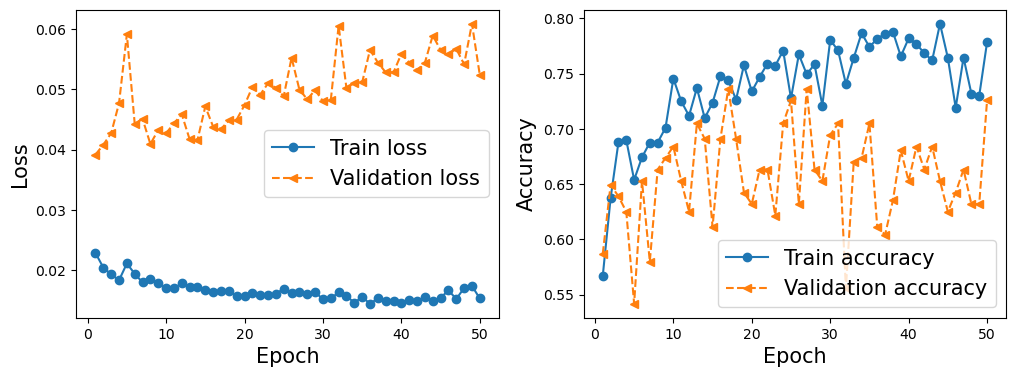

In [ ]:
#学習曲線の描画
train_acc = []
train_loss = []
val_acc = []
val_loss = []
# Define x_arr (the x-axis values) as the number of epochs
x_arr = range(1, epoch + 1)

for i in range(epoch):
  train_acc.append(train_acc_list[i].cpu().detach().numpy())
  train_loss.append(train_loss_list[i])
  val_acc.append(val_acc_list[i].cpu().detach().numpy())
  val_loss.append(val_loss_list[i])

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the training and validation loss
ax[0].plot(x_arr, train_loss, '-o', label='Train loss')
ax[0].plot(x_arr, val_loss, '--<', label='Validation loss')
ax[0].legend(fontsize=15)
ax[0].set_xlabel('Epoch', size=15)
ax[0].set_ylabel('Loss', size=15)

# Plot the training and validation accuracy on the second subplot
ax[1].plot(x_arr, train_acc, '-o', label='Train accuracy')
ax[1].plot(x_arr, val_acc, '--<', label='Validation accuracy')
ax[1].legend(fontsize=15)
ax[1].set_xlabel('Epoch', size=15)
ax[1].set_ylabel('Accuracy', size=15)


plt.savefig(f'{save_path}/learning_curve.png')
plt.show()


In [ ]:
# # 绘制ROC曲线图
# fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.savefig(save_path+f'/ROC_Curve.png')
# plt.show()

### 全参数冻结,在整个数据集上验证